# MaskRCNN Detection and Segmentation | proximity-quadrotor-learning

https://github.com/idsia-robotics/proximity-quadrotor-learning  
https://github.com/matterport/Mask_RCNN

## Settings

In [1]:
################################
### KNOWN IMPORTS
######

import math
import os
import time
import errno
import random
import sys
import gc
from datetime import datetime

# %tensorflow_version 1.x
import tensorflow as tf

# when importing keras, please notice:
#   https://stackoverflow.com/a/57298275/10866825
#   https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# !pip install resnet
# import resnet as kr

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# -- for GradCAM
!pip install tf-keras-vis
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm


################################
### PATHS
######

# this file goes into the 'PROJECT_ROOT/src/' folder to work properly with the following paths

try:
  import google.colab
  IN_COLAB = True
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  drive.mount('/content/drive')
  %cd '/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks/'
except:
  IN_COLAB = False
  from cv2 import imshow as cv2_imshow


this_folder = os.path.realpath('.') # see https://stackoverflow.com/a/32711758/10866825 for details
lib_folder = os.path.join(this_folder, './functions/')
original_models_folder = os.path.join(this_folder, './../dev-models/_originals/') # Dario's original trained models (https://drive.switch.ch/index.php/s/Idsyf8WIwQpvRMF)
original_datasets_folder = os.path.join(this_folder, './../dev-datasets/_originals/') # Dario's original dataset (https://drive.switch.ch/index.php/s/8clDQNH645ZjWDD)
backgrounds_folder = os.path.join(this_folder, './../dev-datasets/_backgrounds/')
new_models_folder = os.path.join(this_folder, './../dev-models/')
new_datasets_folder = os.path.join(this_folder, './../dev-datasets/')
visualization_folder = os.path.join(this_folder, './../dev-visualization/')

dario_model_path = original_models_folder + 'v1_model_train_size_50000_rep_1.h5'
dario_train_path = original_datasets_folder + 'dario/v1_train.pickle'
dario_test_path = original_datasets_folder + 'dario/v1_test.pickle'
green_test_path = original_datasets_folder + 'dario/green_test.pickle'



################################
### CUSTOM IMPORTS
######

sys.path.append(lib_folder)
import general_utils
import keras_utils

import importlib
importlib.reload(general_utils)
importlib.reload(keras_utils)

Mounted at /content/drive
/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks


<module 'keras_utils' from '/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks/./functions/keras_utils.py'>

## MaskRCNN

### Dataset

Here, **regression variables** in the ground truth are used to retrieve **classification variables** (added to the dataset `y`) by discretizing continous values accordingly to arbitrary defined bin intervals. Train set size is reduced to avoid overloads.

In [2]:
# # from 0 to 24k
# dataset_start_index = 0
# dataset_keep_ratio = 0.38
# # from 24k to 55k
# dataset_start_index = 24000
# dataset_keep_ratio = 0.5
# # from 55k to 64k
# dataset_start_index = 55000
# dataset_keep_ratio = 0.15

orig_img, orig_x, orig_y, orig_actual, orig_odom = general_utils.get_dataset_from_pickle(dario_test_path, 0, 1)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks/./../dev-datasets/_originals/dario/v1_test.pickle
dataset original shape: (11035, 3)
dataset keep shape: 	(11035, 3)
img_data shape: 	(11035,)
x_data shape: 		(11035, 60, 108, 3)
y_data shape: 		(11035, 4)
odom_dataset shape: 	(11035, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (11035,)
y_data_for_network single classification variable (4:8) 	 (11035, 3)


In [29]:
# import seaborn as sns

# for i, varname in enumerate(['X', 'Y', 'Z', 'W']):
#   sns.displot(orig_actual[:,i], kind="kde", fill=True).set(title='{} distribution'.format(varname))

# for i, varname in enumerate(['X class', 'Y class', 'Z class', 'W class']):
#   sns.displot(orig_actual[:,4+i], fill=True).set(title='{} distribution'.format(varname))

nicky_x shape (1119, 160, 160, 1)
nicky_y shape (1119, 4)


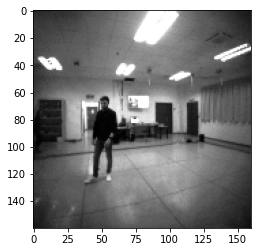

In [ ]:
nicky_train_path = original_datasets_folder + 'nicky/160x160HimaxMixedTrain_12_03_20_nicky.pickle'
nicky_test_path = original_datasets_folder + 'nicky/160x96HimaxMixedTest_12_03_20_nicky.pickle'
others_train_path = original_datasets_folder + 'nicky/160x160HimaxTrain16_4_2020_others.pickle'
others_test_path = original_datasets_folder + 'nicky/160x160HimaxTest16_4_2020_others.pickle'

nicky_pickle = pd.read_pickle(others_test_path)
nicky_h = int(nicky_pickle['h'].values[0])
nicky_w = int(nicky_pickle['w'].values[0])
nicky_c = int(nicky_pickle['c'].values[0])

nicky_x = nicky_pickle['x'].values
nicky_x = np.vstack(nicky_x[:]).astype(np.float32)
nicky_x = np.reshape(nicky_x, (-1, nicky_h, nicky_w, nicky_c))
print('nicky_x shape', nicky_x.shape)

nicky_y = nicky_pickle['y'].values
nicky_y = np.vstack(nicky_y[:]).astype(np.float32)
print('nicky_y shape', nicky_y.shape)

plt.imshow(nicky_x[0][:,:,0], cmap='Greys_r')

### Settings

I was initially working on [this](https://github.com/matterport/Mask_RCNN/issues/1797#issuecomment-616153142) Notebook which is a compatible version of [original Mask_RCNN](https://github.com/matterport/Mask_RCNN), ported on Colab. Unfortunately, it was not working with GPU since TensorFlow 1.x has no native support for it, so I was trying to install `tensorflow-gpu==1.9.0` as the previous Notebook was using, but [downgrading CUDA](https://stackoverflow.com/questions/62584399/google-colab-gpus-tensorflow-1-x) to version 9.

Then I finally found [this article](https://www.immersivelimit.com/tutorials/mask-rcnn-for-windows-10-tensorflow-2-cuda-101) featuring a [MASK RCNN version for TensorFlow 2](https://github.com/akTwelve/Mask_RCNN) which seems to work amazingly.

Using GPU rather than CPU it is possible to make inference 80x times faster than before.

In [ ]:
################################
### LIBRARY INSTALL
######

repo_folder = lib_folder + 'Mask_RCNN_tf2_akTwelve/'

%cd $repo_folder
!pip install -r requirements.txt
!python setup.py clean --all install

/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks/functions/Mask_RCNN_tf2_akTwelve
     |████████████████████████████████| 204kB 12.9MB/s 
     |████████████████████████████████| 163kB 29.4MB/s 
running clean
removing 'build/lib' (and everything under it)
removing 'build/bdist.linux-x86_64' (and everything under it)
'build/scripts-3.6' does not exist -- can't clean it
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/lib
creating build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/vi

In [ ]:
################################
### LIBRARY IMPORTS
### from https://github.com/matterport/Mask_RCNN/issues/1797#issuecomment-616153142
######

import scipy
import skimage
import h5py
import cython

import tensorflow
from tensorflow.python.keras.engine import saving

print('GPU:', tensorflow.test.gpu_device_name())

import skimage.io

# requires https://github.com/matterport/Mask_RCNN/issues/6#issuecomment-341495268 
# on Windows also
#   https://github.com/cocodataset/cocoapi/blob/master/README.txt
#   https://stackoverflow.com/a/32127632/10866825
#   https://github.com/cocodataset/cocoapi/issues/9#issuecomment-437956213
from pycocotools.coco import COCO
from mrcnn.config import Config

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
ROOT_DIR = repo_folder
sys.path.append(ROOT_DIR)

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

GPU: /device:GPU:0


In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
%%time

### Configuration

class InferenceConfig(coco.CocoConfig):
  # Set batch size to 1 since we'll be running inference on
  # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
  GPU_COUNT = 1
  IMAGES_PER_GPU = 10

config = InferenceConfig()
config.display()


# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=ROOT_DIR)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True) 


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     10
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 10
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE       

In [ ]:
def MaskRCNN_detect_batch(model, images, batch_size):
  step = begin = batch_size
  end = len(images) + 1 # last `len(images) % step` images are ignored since the model need exactly `batch_size` images

  prev = 0
  detections = []
  print('Detection started for {} images...'.format(len(images)))

  for curr in range(begin, end, step):
    print('Detecting', prev, curr)
    detections.extend(model.detect(images[prev:curr], verbose=0))
    prev = curr

  print('Detection finished.')
  return detections

### Crop images

Before (4129, 160, 160, 1)
After (4129, 96, 160, 1)


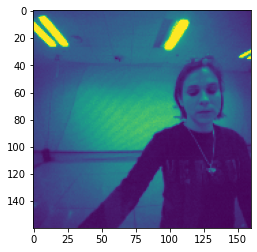

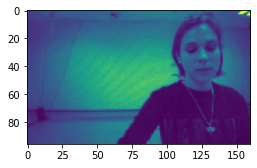

In [ ]:
w, h = 160, 96
x = int(nicky_x[0].shape[0]/2 - w/2)
y = int(nicky_x[0].shape[1]/2 - h/2)
nicky_crop = nicky_x[:,y:y+h, x:x+w]

print('Before', nicky_x.shape)
print('After', nicky_crop.shape)

## Test
id = np.random.randint(nicky_x.shape[0])
plt.figure(0, figsize=(4,4))
plt.imshow(nicky_x[id][:,:,0])
plt.show()
plt.figure(0, figsize=(4,4))
plt.imshow(nicky_crop[id][:,:,0])
plt.show()

### Demo

In [ ]:
%%time

### Image selection

images = []

# random images
# file_names = next(os.walk(IMAGE_DIR))[2]
# images.append(skimage.io.imread(os.path.join(IMAGE_DIR, np.random.choice(file_names))))
# images.append(skimage.io.imread(os.path.join(IMAGE_DIR, np.random.choice(file_names))))
# images.append(skimage.io.imread(os.path.join(IMAGE_DIR, np.random.choice(file_names))))
# images.append(skimage.io.imread(os.path.join(IMAGE_DIR, np.random.choice(file_names))))

# darios's dataset
# images.extend(orig_img[list(range(10))])

# nicky's dataset
images.extend(nicky_x[list(range(10))])


### Inference

detections = MaskRCNN_detect_batch(model, images, config.IMAGES_PER_GPU)

Detection started for 10 images...
Detecting 0 10
Detection finished.
CPU times: user 9.69 s, sys: 4.59 s, total: 14.3 s
Wall time: 18.3 s


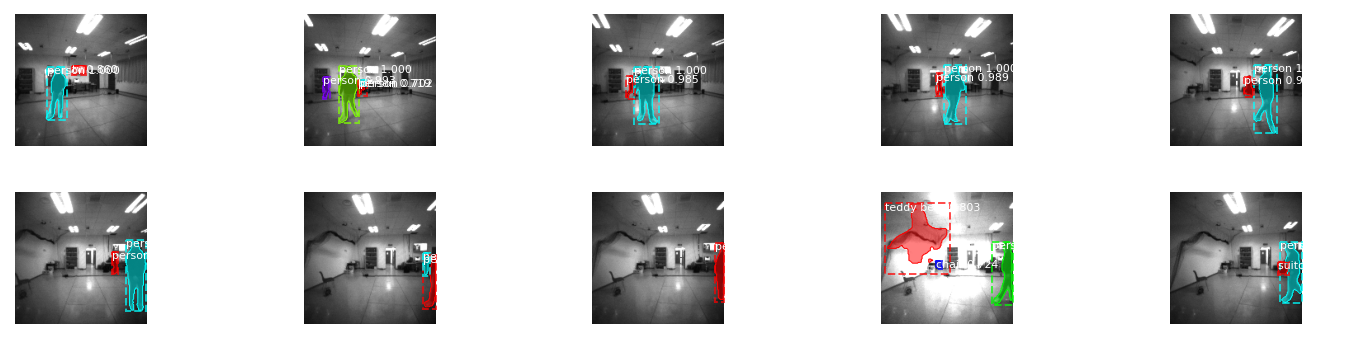

In [ ]:
### Show results

ncols = 5
nrows = int(np.ceil(len(detections)/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})

for idx in range(len(detections)):
  cell = general_utils.subplots_get_cell(len(detections), nrows, ncols, idx, ax)
  
  det = detections[idx]
  img = images[idx]
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).astype(np.uint8) if images[idx].shape[2] == 1 else img
  visualize.display_instances(img, det['rois'], det['masks'], det['class_ids'], class_names, det['scores'], ax=cell)

### Full datset inference + export

Every image in the dataset is passed to the Mask RCNN model for inference: objects detection and segmentation.  
The process is computationally very expensive.

#### Dario's dataset

In [ ]:
%%time

### Inference

images = orig_img
detections = MaskRCNN_detect_batch(model, images, config.IMAGES_PER_GPU)

Detection started for 11035 images...
Detecting 0 10
Detecting 10 20
Detecting 20 30
Detecting 30 40
Detecting 40 50
Detecting 50 60
Detecting 60 70
Detecting 70 80
Detecting 80 90
Detecting 90 100
Detecting 100 110
Detecting 110 120
Detecting 120 130
Detecting 130 140
Detecting 140 150
Detecting 150 160
Detecting 160 170
Detecting 170 180
Detecting 180 190
Detecting 190 200
Detecting 200 210
Detecting 210 220
Detecting 220 230
Detecting 230 240
Detecting 240 250
Detecting 250 260
Detecting 260 270
Detecting 270 280
Detecting 280 290
Detecting 290 300
Detecting 300 310
Detecting 310 320
Detecting 320 330
Detecting 330 340
Detecting 340 350
Detecting 350 360
Detecting 360 370
Detecting 370 380
Detecting 380 390
Detecting 390 400
Detecting 400 410
Detecting 410 420
Detecting 420 430
Detecting 430 440
Detecting 440 450
Detecting 450 460
Detecting 460 470
Detecting 470 480
Detecting 480 490
Detecting 490 500
Detecting 500 510
Detecting 510 520
Detecting 520 530
Detecting 530 540
Detecting 

In [ ]:
### Saving

# save_notes = 'detections orig start{} total{}'.format(dataset_start_index, len(images))
# save_notes = 'detections orig_test total{}'.format(len(images))
save_folder = general_utils.create_datetime_folder(visualization_folder + 'maskRCNN/', save_notes)
save_name = save_folder + save_notes + '.npy'
np.save(save_name, detections)

print(save_name)

/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-visualization/maskRCNN/20201022_121833 detections orig_test total11035/detections orig_test total11035.npy


#### Nicky's dataset

In [ ]:
%%time

### Inference

images = nicky_x
detections = MaskRCNN_detect_batch(model, images, config.IMAGES_PER_GPU)

Detection started for 1119 images...
Detecting 0 10
Detecting 10 20
Detecting 20 30
Detecting 30 40
Detecting 40 50
Detecting 50 60
Detecting 60 70
Detecting 70 80
Detecting 80 90
Detecting 90 100
Detecting 100 110
Detecting 110 120
Detecting 120 130
Detecting 130 140
Detecting 140 150
Detecting 150 160
Detecting 160 170
Detecting 170 180
Detecting 180 190
Detecting 190 200
Detecting 200 210
Detecting 210 220
Detecting 220 230
Detecting 230 240
Detecting 240 250
Detecting 250 260
Detecting 260 270
Detecting 270 280
Detecting 280 290
Detecting 290 300
Detecting 300 310
Detecting 310 320
Detecting 320 330
Detecting 330 340
Detecting 340 350
Detecting 350 360
Detecting 360 370
Detecting 370 380
Detecting 380 390
Detecting 390 400
Detecting 400 410
Detecting 410 420
Detecting 420 430
Detecting 430 440
Detecting 440 450
Detecting 450 460
Detecting 460 470
Detecting 470 480
Detecting 480 490
Detecting 490 500
Detecting 500 510
Detecting 510 520
Detecting 520 530
Detecting 530 540
Detecting 5

In [ ]:
### Saving

save_notes = 'detections others test 160x160 {}'.format(len(images))
# save_notes = 'detections nicky cropped 160x96 {}'.format(len(images))
save_folder = general_utils.create_datetime_folder(visualization_folder + 'maskRCNN/', save_notes)
save_name = save_folder + save_notes + '.npy'
np.save(save_name, detections)

print(save_name)

/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks/./../dev-visualization/maskRCNN/20210110_173734 detections others test 160x160 1119/detections others test 160x160 1119.npy


### Re-import inference + analysis

In [ ]:
# loaded_path = visualization_folder + 'maskRCNN/20201017_180347 detections orig start0 total24215/detections orig start0 total24215.npy'
# loaded_path = visualization_folder + 'maskRCNN/20201016_183639 detections orig start24000 total31863/detections orig start24000 total31863.npy'
# loaded_path = visualization_folder + 'maskRCNN/20201017_200003 detections orig start55000 total8726/detections orig start55000 total8726.npy'
loaded_path = visualization_folder + 'maskRCNN/20210110_173734 detections others test 160x160 1119/detections others test 160x160 1119.npy'

loaded_detections = np.load(loaded_path, allow_pickle=True)
loaded_images = nicky_x
loaded_y = nicky_y

print('length', len(loaded_detections))
print(loaded_detections[0].keys())

length 1110
dict_keys(['rois', 'class_ids', 'scores', 'masks'])


In [ ]:
def show_images(images_idx, images_data, detections, ncols, ratio = (5, 5)):
  nrows = int(np.ceil(len(images_idx)/ncols))
  fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*ratio[0],nrows*ratio[1]), subplot_kw={'xticks': [], 'yticks': []})

  for counter, index in enumerate(images_idx):
    det = detections[index]
    cell = general_utils.subplots_get_cell(len(images_idx), nrows, ncols, counter, ax)
    title = 'frame {} | {}'.format(index, [class_names[c] for c in det['class_ids']])
    
    img = images_data[index]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).astype(np.uint8) if images_data[index].shape[2] == 1 else img

    if len(det['class_ids']) > 0:
      visualize.display_instances(img, det['rois'], det['masks'], det['class_ids'], class_names, det['scores'], ax=cell, title=title)
    else:
      cell.set_title(title)
      cell.imshow(img)


def filter_class_size(classes, boxes, class_id, size_greater_than, size_threshold):
  class_found = np.argwhere(classes == class_id)[:,0]
  class_size = np.array([(x2-x1)*(y2-y1) for y1, x1, y2, x2 in boxes[class_found]])
  class_filter = np.argwhere(class_size > size_threshold if size_greater_than else class_size < size_threshold)[:,0]
  return class_filter


def sort_class_size(classes, boxes, class_id, reverse=True):
  class_found = np.argwhere(classes == class_id)[:,0]
  class_size = np.array([(x2-x1)*(y2-y1) for y1, x1, y2, x2 in boxes[class_found]])
  class_sort = np.argsort(class_size)
  return class_sort[::-1] if reverse else class_sort

#### Exploratory analysis

In [ ]:
none_idx = []       # stores indices of images with NO PEOPLE
error_idx = []      # stores indices of images with TOO SMALL PEOPLE (false positive)
single_idx = []     # stores indices of images with ONE PERSON
multiple_idx = []   # stores indices of images with MULTIPLE PEOPLE

for counter, det in enumerate(loaded_detections):
  classes = det['class_ids']
  detected_pers = classes.tolist().count(class_names.index('person'))

  if detected_pers == 0:
    none_idx.append(counter)

  elif detected_pers > 0:
    people_real = filter_class_size(classes, det['rois'], class_names.index('person'), size_greater_than=True, size_threshold=450)

    if len(people_real) == 0:
      error_idx.append(counter)

    elif len(people_real) == 1:
      single_idx.append(counter)

    elif len(people_real) > 1:
      multiple_idx.append(counter)

In [ ]:
print('Failures:', len(none_idx))
show_images(none_idx[:50], loaded_images, loaded_detections, ncols=8, ratio=(5,3))

Failures: 0


ValueError: ignored

In [ ]:
print('Multiple people:', len(multiple_idx))
show_images(multiple_idx[:50], loaded_images, loaded_detections, ncols=5, ratio=(5,3))

In [ ]:
print('False positives:', len(error_idx))
show_images(error_idx[:50], loaded_images, loaded_detections, ncols=5, ratio=(5,3))

Single: 10865


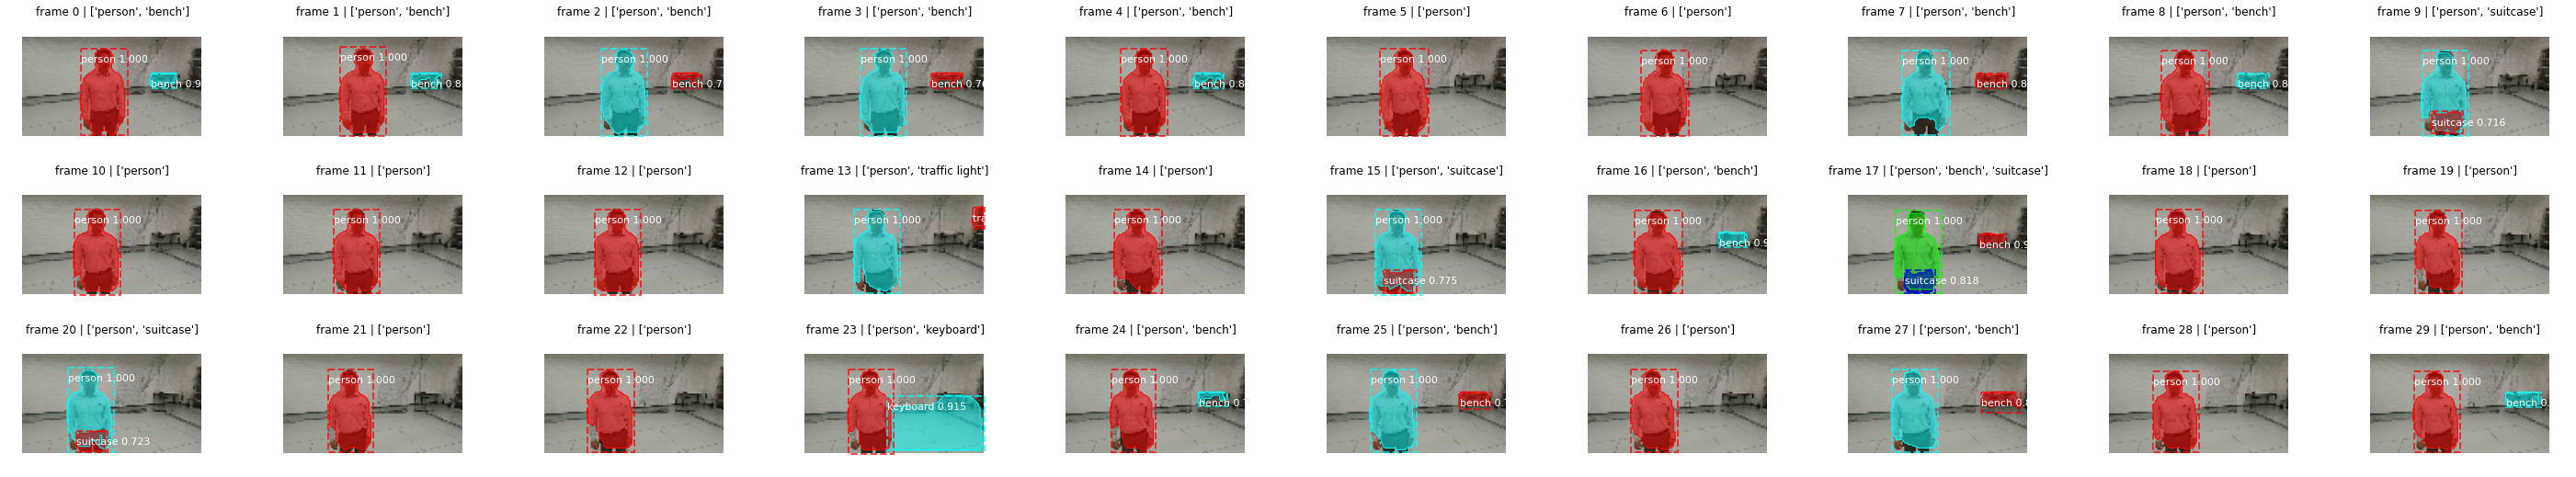

In [ ]:
print('Single:', len(single_idx))
show_images(single_idx[:30], loaded_images, loaded_detections, ncols=10, ratio=(5,3))

### ETL for background removal

#### Compute centroids

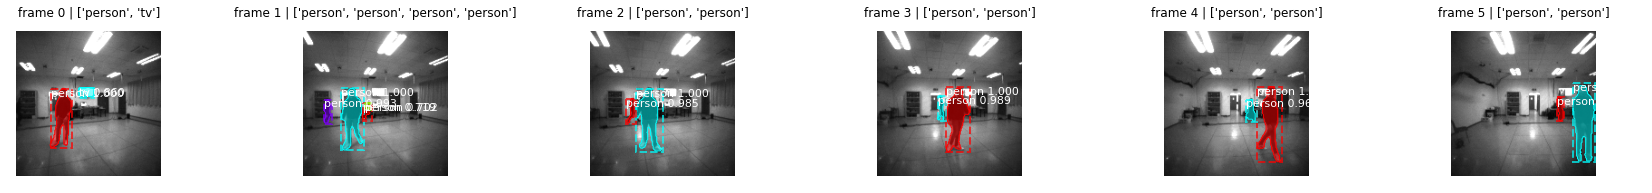

In [ ]:
show_images(range(6), loaded_images, loaded_detections, 6, ratio=(5,3))

Total centroids: 1110
Valid centroids: 1110
None  centroids: 0


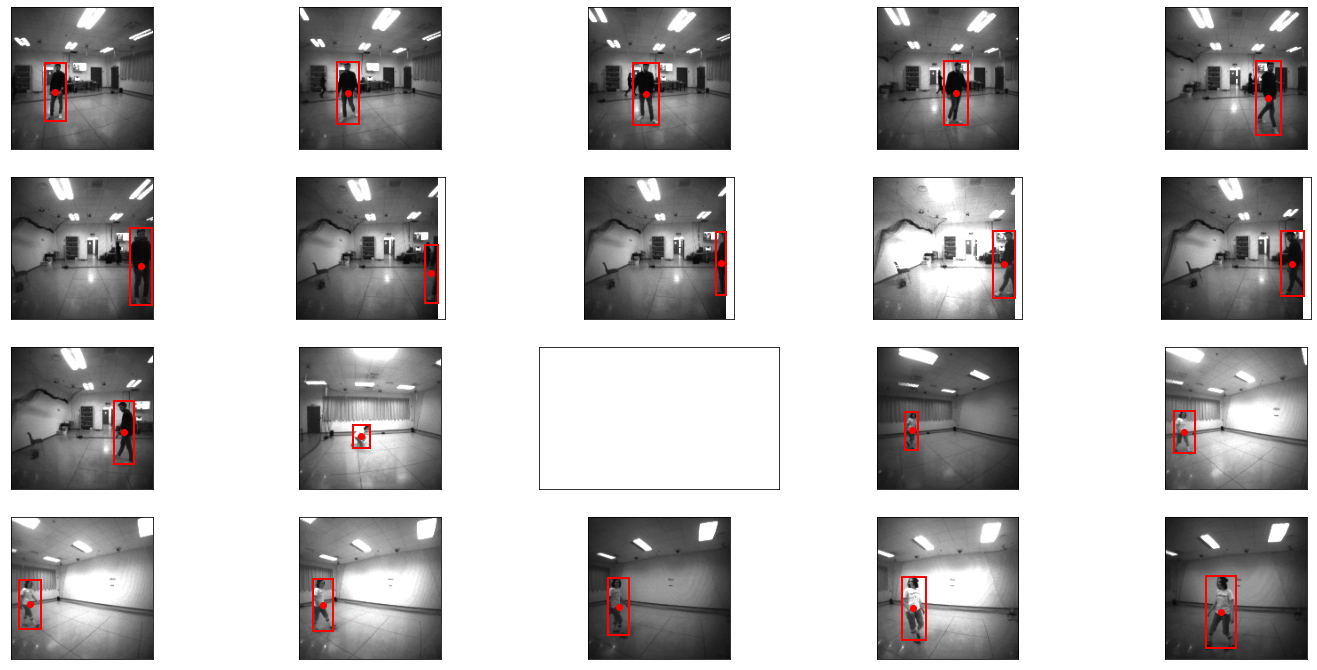

In [ ]:
people_box = []
people_mask = []
people_centroid = []

nplotted = 20 # len(loaded_detections)
ncols = 5
nrows = int(np.ceil(nplotted/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})

for counter, det in enumerate(loaded_detections):
  classes = det['class_ids']
  people_real = filter_class_size(classes, det['rois'], class_names.index('person'), size_greater_than=True, size_threshold=400)

  if len(people_real) == 0:
    people_box.append([None])
    people_mask.append([None])
    people_centroid.append([None])

  elif len(people_real) > 0:
    people_sizesort = sort_class_size(classes, det['rois'], class_names.index('person'))

    biggest_box = det['rois'][people_sizesort[0]] # get bounding box of the largest person
    biggest_mask = det['masks'][:,:,people_sizesort[0]] # get mask of the largest person

    y1, x1, y2, x2 = biggest_box
    centroid = ((x1+x2)//2, (y1+y2)//2)
    
    people_box.append(biggest_box)
    people_mask.append(biggest_mask)
    people_centroid.append(centroid)

    if counter < nplotted:
      cell = general_utils.subplots_get_cell(nplotted, nrows, ncols, counter, ax)
      img = loaded_images[counter]
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).astype(np.uint8) if img.shape[2] == 1 else img
      cell.imshow(img)
      cell.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none'))
      cell.scatter(centroid[0], centroid[1], color='r')

total_centroids_count = len(people_centroid)
nonzero_centroids_count = len(np.nonzero(people_centroid)[0])
print('Total centroids:', len(people_centroid))
print('Valid centroids:', len(np.nonzero(people_centroid)[0]))
print('None  centroids:', total_centroids_count - nonzero_centroids_count)

assert len(people_centroid) == len(people_box) == len(people_mask)

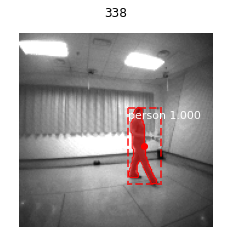

In [ ]:
fig, ax = plt.subplots(1, 1)

ii = np.random.randint(len(people_box))
boxes = np.array([people_box[ii]])
masks = people_mask[ii][:,:,np.newaxis]
classes = np.array([1]) # person placeholder
scores = np.array([1]) # score placeholder
centroid = people_centroid[ii]

img = loaded_images[ii]
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).astype(np.uint8) if img.shape[2] == 1 else img

visualize.display_instances(img, boxes, masks, classes, class_names, scores, ax=ax, title=ii)
ax.scatter(centroid[0], centroid[1], color='r')

#### Transform and export data

In [ ]:
### Create object for saving

export = []
count_none = 0

for idx in range(len(people_centroid)):
  if people_centroid[idx][0] == None:
    count_none += 1

  tup = {
      'image': loaded_images[idx], 
      'centr': tuple(people_centroid[idx]),
      'bbox': tuple(people_box[idx]), 
      'mask': np.where(people_mask[idx], 1, 0),
      'gt': loaded_y[idx]
  }
  export.append(tup)


export = np.array(export)
print('export shape', export.shape)
print('export[0][image] shape', np.shape(export[0]['image']))
print('export[0][centr] shape', np.shape(export[0]['centr']))
print('export[0][bbox] shape', np.shape(export[0]['bbox']))
print('export[0][mask] shape', np.shape(export[0]['mask']))
print('export[0][gt] shape', np.shape(export[0]['gt']))

print('\nNo person images count:', count_none)
for e in export:
  if e['centr'][0] == None:
    print('No person image details: {{image: ndarray, centr: {}, bbox: {}, mask: {}}}'.format(e['centr'], e['bbox'], e['mask']))
    break

export shape (1110,)
export[0][image] shape (160, 160, 1)
export[0][centr] shape (2,)
export[0][bbox] shape (4,)
export[0][mask] shape (160, 160)
export[0][gt] shape (4,)

No person images count: 12
No person image details: {image: ndarray, centr: (None,), bbox: (None,), mask: [0]}


In [ ]:
### Saving

loaded_dir, loaded_file = os.path.split(loaded_path)
loaded_name, _ = os.path.splitext(loaded_file)
export_path = os.path.join(loaded_dir, 'maskrcnn final - {}.npy'.format(loaded_name))
print(export_path)

np.save(export_path, export)

/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks/./../dev-visualization/maskRCNN/20210110_173734 detections others test 160x160 1119/maskrcnn final - detections others test 160x160 1119.npy


#### Re-import and test

shape (1110,)
keys dict_keys(['image', 'centr', 'bbox', 'mask', 'gt'])


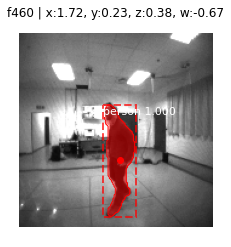

In [ ]:
### Re-import

# export_path =  visualization_folder + 'maskRCNN/20201017_180347 detections orig start0 total24215/maskrcnn final - detections orig start0 total24000.npy'
# export_path =  visualization_folder + 'maskRCNN/20201016_183639 detections orig start24000 total31863/maskrcnn final A - detections orig start24000 total15500.npy'
# export_path =  visualization_folder + 'maskRCNN/20201016_183639 detections orig start24000 total31863/maskrcnn final B - detections orig start24000 total15500.npy'
# export_path =  visualization_folder + 'maskRCNN/20201017_200003 detections orig start55000 total8726/maskrcnn final - detections orig start55000 total8720.npy'
reload_export = np.load(export_path, allow_pickle=True)

print('shape', np.shape(reload_export))
print('keys', reload_export[0].keys())


### Test

ii = np.random.randint(len(reload_export))

cur = reload_export[ii]
boxes = np.array([cur['bbox']])
masks = cur['mask'][:,:,np.newaxis]
centroid = cur['centr']
gt = cur['gt']
classes = np.array([1]) # person placeholder
scores = np.array([1]) # score placeholder

img = cur['image']
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).astype(np.uint8) if img.shape[2] == 1 else img

fig, ax = plt.subplots(1, 1)
title = 'f{} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(ii, gt[0], gt[1], gt[2], gt[3])
visualize.display_instances(img, boxes, masks, classes, class_names, scores, ax=ax, title=title)
ax.scatter(centroid[0], centroid[1], color='r')
plt.show()

shape (1110,)
dict_keys(['image', 'centr', 'bbox', 'mask', 'gt'])



Text(0.5, 1.0, 'f371 | x:2.21, y:-0.42, z:0.50, w:0.62')

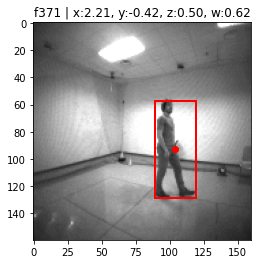

In [ ]:
### Test with pure Matplotlib

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2

export_path = export_path # visualization_folder + 'maskRCNN/20210110_173734 detections others test 160x160 1119/maskrcnn final - detections others test 160x160 1119.npy'
# export_path = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/visualization/maskRCNN/20201016_155352 detections nicky test cropped 160x96 803/maskrcnn final - nicky test cropped 160x96 803.npy'
reload_export = np.load(export_path, allow_pickle=True)

print('shape', np.shape(reload_export))
print(reload_export[0].keys())
print()

idx = np.random.randint(len(reload_export))
dicty = reload_export[idx]

img = dicty['image']
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).astype(np.uint8) if img.shape[2] == 1 else img
y1, x1, y2, x2 = dicty['bbox']
x, y = dicty['centr']
mask = dicty['mask']
gt = dicty['gt']

plt.imshow(img)
# plt.imshow(mask, cmap='Greys_r', alpha=0.5)
plt.gca().add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none'))
plt.scatter(x, y, color='r')
plt.title('f{} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(idx, gt[0], gt[1], gt[2], gt[3]))

## Background replacement with computed masks

#### Merge MaskRCNN files

In [ ]:
bp = visualization_folder + 'maskRCNN/'
pps =  [
  # '/20201017_180347 detections orig_train start0 total24215/maskrcnn final - detections orig start0 total24000.npy',
  # '/20201016_183639 detections orig_train start24000 total31863/maskrcnn final A - detections orig start24000 total15500.npy',
  # '/20201016_183639 detections orig_train start24000 total31863/maskrcnn final B - detections orig start24000 total15500.npy',
  # '/20201017_200003 detections orig_train start55000 total8726/maskrcnn final - detections orig start55000 total8720.npy'
  '20201022_121833 detections orig_test total11035/maskrcnn final - detections orig_test total11035.npy'
]

print('loading...')
parts = [np.load(bp + pp, allow_pickle=True) for pp in pps]
print('loaded')

dataset = np.hstack(tuple(parts[:]))
print('dataset shape', np.shape(dataset))
print(dataset[np.random.randint(len(dataset))].keys())

dataset_start_index = 0
dataset_keep_ratio = 1
keep = dataset_start_index + int(len(dataset) * dataset_keep_ratio)
dataset = dataset[dataset_start_index:keep] # reducing dataset size
print('dataset keep shape: \t' + str(dataset.shape))

dataset = np.array([[v for k, v in d.items()] for d in dataset])
print('dataset transform shape', np.shape(dataset))

loading...
loaded
dataset shape (11030,)
dict_keys(['image', 'centr', 'bbox', 'mask', 'gt'])
dataset keep shape: 	(11030,)
dataset transform shape (11030, 5)


#### Create dataset for training

In [ ]:
### Export
bg_type = '20'
replace_imgs = general_utils.load_images_from_folder(new_datasets_folder + '_backgrounds/backgrounds-' + bg_type)
ninputs = len(dataset) # samples considered into orig_img dataset
nbackgrounds = len(replace_imgs) if replace_imgs is not None else 1

count_total = ninputs * nbackgrounds
skip_frames = 10 # considering original inputs
log_each = 1000 # considering original inputs and skip
max_per_dataframe = 55000 # number of sample each dataframe can have

save_each = int(np.ceil(max_per_dataframe / nbackgrounds))
frames_enumerator = range(0, ninputs, skip_frames)

count_real = len(frames_enumerator) * nbackgrounds
part_total = int(np.ceil(count_real / (save_each * nbackgrounds))) # number of dataframes that will be saved
part_current = 0 # current saved dataframe
timestr = time.strftime("%Y%m%d_%H%M%S")

print('orig_imgs: \t', ninputs)
print('log each: \t', log_each)
print('save each: \t', save_each, '\n')

print('replace_imgs: \t', nbackgrounds)
print('count_total: \t', count_total, '\n')

print('skip_frames: \t', skip_frames)
print('count_real: \t', count_real)
print('part_total: \t', part_total, '\n')


edited = [] # new images with no background
errors = [] # index only of error frames
blank = np.ones((general_utils.image_height, general_utils.image_width, 3)) # for errors


if replace_imgs is None:
  dataset_notes = 'MASKRCNN remove background - total {1} (start{0})'.format(dataset_start_index, count_real)
else:
  dataset_notes = 'MASKRCNN replace {0} samples TEST (start{1}, skip{2} = {3}) with {4} backgrounds - total {5}'.format(ninputs, dataset_start_index, skip_frames, ninputs//skip_frames, bg_type, count_real)

dataset_folder = new_datasets_folder + dataset_notes + '/'



def save_pickle(data, timestr, folder, count_total, part_current, part_total):
  picklename = '{0}_maskrcnn_replacebg_df{1}_{2}of{3}.pickle'.format(timestr, count_total, part_current, part_total)
  exportpath = folder + picklename
  general_utils.create_folder_if_not_exist(folder)

  exportdf = pd.DataFrame(list(data))
  exportdf.to_pickle(exportpath)
  print('Export complete in', exportpath)



print('Exporting...')

for count, frame_index in enumerate(frames_enumerator):
  
  if count != 0 and count % log_each == 0:
    print('Progress: {0}/{1}'.format(frame_index, ninputs))

  if count != 0 and count % save_each == 0:
    part_current += 1
    save_pickle(edited, timestr, dataset_folder, count_real, part_current, part_total)
    del edited # delete object for freeing memory
    gc.collect() # tells the garbage collector to free unused memory
    edited = [] # reinstantiate result array

  target = dataset[frame_index, 4][0:4]
  odom = (None, None)
  
  try:
    images = general_utils.image_background_replace_mask(
        img = dataset[frame_index, 0], mask = dataset[frame_index, 3],
        smooth = True, debug = False, replace_bg_images = replace_imgs
    )
  except:
    # images = [blank] # otherwise, indexes become a mess
    errors.append(frame_index)
  
  for img in images:
    edited.append((img, target, odom))


# remaining samples
print('Progress: {0}/{1}'.format(frame_index, ninputs))
part_current += 1
save_pickle(edited, timestr, dataset_folder, count_real, part_current, part_total)
del edited # delete object for freeing memory
gc.collect() # tells the garbage collector to free unused memory


print('\nCOMPLETED')
print('errors shape', np.shape(errors))
print('\nerrors: ', errors)

orig_imgs: 	 11030
log each: 	 1000
save each: 	 2750 

replace_imgs: 	 20
count_total: 	 220600 

skip_frames: 	 10
count_real: 	 22060
part_total: 	 1 

Exporting...
Progress: 10000/11030
Progress: 11020/11030
Export complete in /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/MASKRCNN replace 11030 samples TEST (start0, skip10 = 1103) with backgrounds-20 backgrounds - total 22060/20201022_133340_maskrcnn_replacebg_df22060_1of1.pickle

COMPLETED
errors shape (0,)

errors:  []


## Training

### Experiments

In [ ]:
### Data

dataset_folder = new_datasets_folder + 'MASKRCNN replace 31860 samples (start24000, skip12 = 2655) with 20 backgrounds - total 53100'
reimportpath = dataset_folder + '/20201020_091307_maskrcnn_replacebg_df53100_1of1.pickle'
removebg_img, removebg_x, removebg_y, removebg_actual, _ = general_utils.get_dataset_from_pickle(reimportpath, dataset_keep_ratio=1)

### Model settings

train_img = removebg_img
train_x = removebg_x
train_y = removebg_y
train_actual = removebg_actual

var_index = None # (None: all, 4: x, 5: y, 6: z, 7: w)
retrain_all = True 
from_layer = 24 # (22: activation_6, 24: conv2d_9, 26: batch_normalization_7, 29: flatten_1)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-datasets/MASKRCNN replace 31860 samples (start24000, skip12 = 2655) with 20 backgrounds - total 53100/20201020_091307_maskrcnn_replacebg_df53100_1of1.pickle
dataset original shape: (53100, 3)
dataset keep shape: 	(53100, 3)
img_data shape: 	(53100,)
x_data shape: 		(53100, 60, 108, 3)
y_data shape: 		(53100, 4)
odom_dataset shape: 	(53100, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (53100,)
y_data_for_network single classification variable (4:8) 	 (53100, 3)


In [ ]:
### Training and save

model = keras_utils.network_create(dario_model_path, retrain_all, var_index, view_summary = False, retrain_from_layer = from_layer)
model, history = keras_utils.network_train(model, train_x, train_y, var_index, use_early_stop = False)

keras_utils.network_stats(history, var_index, classification_only = False, view = True, save = False, save_folder = '', save_name = '')
# keras_utils.network_save(model, export_folder, model_name, var_index, save_plot = False)

In [ ]:
# ### Convert MaskRCNN data to be fed into the network
# def maskrcnn_extract_network_data(images, actuals):

#   x_data = 255 - images
#   x_data = np.vstack(x_data[:]).astype(np.float32)
#   x_data = np.reshape(x_data, (-1, images[0].shape[0], images[0].shape[1], 3))

#   y_data_pretty = actuals
#   ytr = np.transpose(y_data_pretty[:,0:4])          # shape (regr_variables, samples) (4, ?)
#   cat_train = to_categorical(y_data_pretty[:,4:8])  # shape (samples, class_variables, categorical) (?, 4, 3)
#   ytc = np.transpose(cat_train, (1, 0, 2))          # shape (class_variables, samples, categorical) (4, ?, 3)
#   y_data_for_network = [ytr[0], ytr[1], ytr[2], ytr[3], ytc[0], ytc[1], ytc[2], ytc[3]]

#   return x_data, y_data_for_network


# ### Model settings

# train_img = dataset[:, 0]
# train_actual = np.array(list(dataset[:, 4]))
# train_x, train_y = maskrcnn_extract_network_data(train_img, train_actual)

# var_index = None # (None: all, 4: x, 5: y, 6: z, 7: w)
# retrain_all = True 
# from_layer = 26 # (22: activation_6, 24: conv2d_9, 26: batch_normalization_7, 29: flatten_1)


# ### Training and save

# model = keras_utils.network_create(dario_model_path, retrain_all, var_index, view_summary = False, retrain_from_layer = from_layer)
# model, history = keras_utils.network_train(model, train_x, train_y, var_index, use_early_stop = False)

# keras_utils.network_stats(history, var_index, classification_only = False, view = True, save = False, save_folder = export_folder, save_name = model_name)
# # keras_utils.network_save(model, export_folder, model_name, var_index, save_plot = False)

### Full training + GradCAM

In [ ]:
### Data

dataset_folder = new_datasets_folder + 'MASKRCNN replace 31860 samples (start24000, skip12 = 2655) with 20 backgrounds - total 53100'
reimportpath = dataset_folder + '/20201020_091307_maskrcnn_replacebg_df53100_1of1.pickle'
removebg_img, removebg_x, removebg_y, removebg_actual, _ = general_utils.get_dataset_from_pickle(reimportpath, dataset_keep_ratio=1)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-datasets/MASKRCNN replace 31860 samples (start24000, skip12 = 2655) with 20 backgrounds - total 53100/20201020_091307_maskrcnn_replacebg_df53100_1of1.pickle
dataset original shape: (53100, 3)
dataset keep shape: 	(53100, 3)
img_data shape: 	(53100,)
x_data shape: 		(53100, 60, 108, 3)
y_data shape: 		(53100, 4)
odom_dataset shape: 	(53100, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (53100,)
y_data_for_network single classification variable (4:8) 	 (53100, 3)


/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-models/prova 

Epoch 1/2
581/581 - 17s - loss: 2.3305 - x_class_loss: 0.7286 - y_class_loss: 0.4877 - z_class_loss: 0.5432 - w_class_loss: 0.5710 - x_class_accuracy: 0.6595 - y_class_accuracy: 0.7973 - z_class_accuracy: 0.7934 - w_class_accuracy: 0.7578 - val_loss: 1.9328 - val_x_class_loss: 0.6307 - val_y_class_loss: 0.3633 - val_z_class_loss: 0.4657 - val_w_class_loss: 0.4731 - val_x_class_accuracy: 0.7111 - val_y_class_accuracy: 0.8551 - val_z_class_accuracy: 0.8202 - val_w_class_accuracy: 0.8044
Epoch 2/2
581/581 - 15s - loss: 1.7903 - x_class_loss: 0.6000 - y_class_loss: 0.3580 - z_class_loss: 0.3742 - w_class_loss: 0.4580 - x_class_accuracy: 0.7314 - y_class_accuracy: 0.8588 - z_class_accuracy: 0.8672 - w_class_accuracy: 0.8089 - val_loss: 1.8167 - val_x_class_loss: 0.5720 - val_y_class_loss: 0.3805 - val_z_class_loss: 0.3608 - val_w_class_loss: 0.5035 - val_x_class_accuracy: 0.7461 - val_y_class_accuracy: 

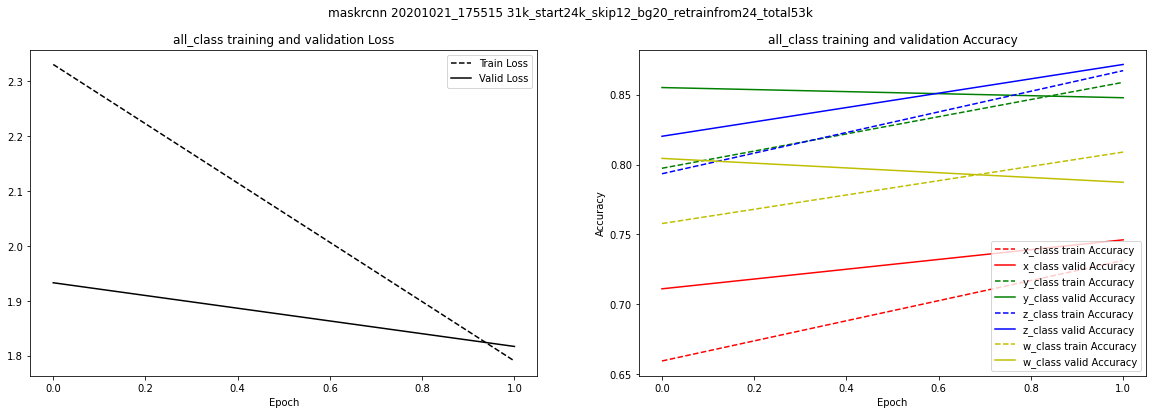

Model saved in /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-models/provamaskrcnn 20201021_175515 31k_start24k_skip12_bg20_retrainfrom24_total53k - v1_all_class_model.h5
Model saved in /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-models/provamaskrcnn 20201021_175515 31k_start24k_skip12_bg20_retrainfrom24_total53k - v1_x_class_model.h5
Model saved in /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-models/provamaskrcnn 20201021_175515 31k_start24k_skip12_bg20_retrainfrom24_total53k - v1_y_class_model.h5
Model saved in /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-models/provamaskrcnn 20201021_175515 31k_start24k_skip12_bg20_retrainfrom24_total53k - v1_z_class_model.h5
Model saved in /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-models/provamaskrcnn 20201021_175515 31k_start24k_skip12_bg20_retrainfrom24_total53k - v1_w_class_model.h5


('/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-models/prova',
 'maskrcnn 20201021_175515 31k_start24k_skip12_bg20_retrainfrom24_total53k')

In [ ]:
### Export models

train_img = removebg_img
train_x = removebg_x
train_y = removebg_y
train_actual = removebg_actual

retrain_all = True
from_layer = 24 # (22: activation_6, 24: conv2d_9, 26: batch_normalization_7, 29: flatten_1)

timestr = time.strftime("%Y%m%d_%H%M%S")
model_name = 'maskrcnn ' + timestr + ' 31k_start24k_skip12_bg20_{0}_total53k'.format('retrainfrom{0}'.format(from_layer) if retrain_all else 'simple')

exportvariants_folder = new_models_folder + model_name + '/'
general_utils.create_folder_if_not_exist(exportvariants_folder)
print(exportvariants_folder, '\n')

keras_utils.network_export_variants(
    dario_model_path, exportvariants_folder, model_name, 
    train_x, train_y, retrain_all, from_layer, epochs = 2, 
    use_lr_reducer = True, use_early_stop = False,
    copy_weights_after_first = True, # if True only the "all_class" network is trained, while the others (x, y, z, w classes) just inherit the weights from the first
    view_stats=True, save_stats=True)

In [ ]:
### Import models

vis_model_all, vis_model_vars = keras_utils.network_import_variants(exportvariants_folder, model_name)

Models imported from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-models/prova


In [ ]:
### Select data

vis_max_samples = 1000
vis_index_start = 1
vis_img, vis_input, vis_actuals, vis_predictions_best, vis_index_start = keras_utils.gradcam_data_select_predict_transform(vis_model_vars, train_img, train_x, train_actual, vis_max_samples, vis_index_start)

selected indexes are from 1 to 1001 

x_class actual 		 ['medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'me

In [ ]:
### GradCAM

max_frames = 5
nplotted = np.min([max_frames, vis_max_samples])

var_types = [0, 1, 2, 3] # X:0, Y:1, Z:2, W:3
loss_types = [0, 1, 2, 3] # low:0, medium:1, high:2, total:3
np.random.seed(general_utils.random_seed)
frames = np.random.choice(range(vis_input.shape[0]), nplotted, p = keras_utils.get_wave_distribution(vis_input.shape[0]))
per_var__loss_folder = visualization_folder + 'gradcam/replacebg/'

keras_utils.gradcam_comparison_varloss(
    vis_img, vis_input, vis_actuals, vis_predictions_best, vis_index_start,
    var_types, loss_types, vis_model_vars , frames, 
    per_var__loss_folder, notes = model_name, title = True, save = False
)